# Exploring data to calculate bunches and gaps

This first half of this notebook is the exploratory code I used to find this method in the first place.  The second half will be a cleaned version that can be run on its own.

## Initialize database connection

So I can load the data I'll need

In [0]:
import getpass
import psycopg2 as pg
import pandas as pd
import pandas.io.sql as sqlio
import plotly.express as px

/usr/local/lib/python3.6/dist-packages/psycopg2/__init__.py:144: UserWarning: The psycopg2 wheel package will be renamed from release 2.8; in order to keep installing from binary please use "pip install psycopg2-binary" instead. For details see: <http://initd.org/psycopg/docs/install.html#binary-install-from-pypi>.
  """)


In [0]:
# Enter database credentials.  Requires you to paste in the user and
# password so it isn't saved in the notebook file
print("Enter database username:")
user = getpass.getpass()
print("Enter database password:")
password = getpass.getpass()

creds = {
  'user': user,
  'password': password,
  'host': "lambdalabs24sfmta.cykkiwxbfvpg.us-east-1.rds.amazonaws.com",
  'dbname': "historicalTransitData"
}

# Set up connection to database
cnx = pg.connect(**creds)
cursor = cnx.cursor()

print('\nDatabase connection successful')

Enter database username:
··········
Enter database password:
··········

Database connection successful


## Load route configuration and schedule data using custom classes

Allows me to build on previous work

In [0]:
# Change this one cell and run all to change to a different route/day
rid = "1"
begin = "2020/6/1 07:00:00"
end = "2020/6/2 07:00:00"  # non-inclusive

In [0]:
# Load in the other classes I wrote (I uploaded class files to colab manually for this)
from schedule import Schedule
from route import Route

# Day is not working right.  We currently have the same data for all days available, so this will still work
# I will investigate why my class isn't pulling data right later, it worked before...
day = "2020-5-20"

schedule = Schedule(rid, day, cnx)
route = Route(rid, day, cnx)

In [0]:
# One thing I was after there
schedule.inbound_table.head(10)

,4277,3825,3893,3848,6296,4026,4027,4028,34015
0,NaN,NaN,NaN,04:32:00,04:37:00,04:44:00,04:50:00,04:56:00,04:59:00
1,NaN,NaN,NaN,04:40:00,04:45:00,04:52:00,04:58:00,05:04:00,05:07:00
2,NaN,NaN,NaN,04:48:00,04:53:00,05:00:00,05:06:00,05:12:00,05:15:00
3,NaN,NaN,NaN,04:56:00,05:01:00,05:08:00,05:14:00,05:20:00,05:23:00
4,NaN,NaN,NaN,05:04:00,05:09:00,05:16:00,05:22:00,05:28:00,05:31:00
5,NaN,NaN,NaN,05:12:00,05:17:00,05:24:00,05:30:00,05:36:00,05:39:00
6,05:00:00,05:10:00,05:16:00,NaN,05:21:00,05:28:00,05:34:00,05:40:00,05:43:00
7,NaN,NaN,NaN,05:20:00,05:25:00,05:32:00,05:38:00,05:44:00,05:47:00
8,05:08:00,05:18:00,05:24:00,NaN,05:29:00,05:36:00,05:42:00,05:48:00,05:51:00
9,05:16:00,05:26:00,05:32:00,NaN,05:37:00,05:44:00,05:50:00,05:56:00,05:59:00


In [0]:
# I didn't have the stops functionality complete in my class, so I'll write it here
# Read in route configuration data
stops = pd.DataFrame(route.route_data['stop'])
directions = pd.DataFrame(route.route_data['direction'])

# Change stop arrays to just the list of numbers
for i in range(len(directions)):
  directions.at[i, 'stop'] = [s['tag'] for s in directions.at[i, 'stop']]

# Find which stops are inbound or outbound
inbound = []
for stop_list in directions[directions['name'] == "Inbound"]['stop']:
  for stop in stop_list:
    if stop not in inbound:
      inbound.append(stop)

outbound = []
for stop_list in directions[directions['name'] == "Outbound"]['stop']:
  for stop in stop_list:
    if stop not in inbound:
      outbound.append(stop)

# Label each stop as inbound or outbound
stops['direction'] = ['none'] * len(stops)
for i in range(len(stops)):
  if stops.at[i, 'tag'] in inbound:
    stops.at[i, 'direction'] = 'inbound'
  elif stops.at[i, 'tag'] in outbound:
    stops.at[i, 'direction'] = 'outbound'

# Convert from string to float
stops['lat'] = stops['lat'].astype(float)
stops['lon'] = stops['lon'].astype(float)

stops.head()

,lat,lon,tag,title,stopId,direction
0,37.79544,-122.39682,4015,Clay St & Drumm St,14015,outbound
1,37.79450,-122.39761,6294,Sacramento St & Davis St,16294,outbound
2,37.79418,-122.40028,6290,Sacramento St & Battery St,16290,outbound
3,37.79403,-122.40155,6314,Sacramento St & Sansome St,16314,outbound
4,37.79384,-122.40307,6307,Sacramento St & Montgomery St,16307,outbound


In [0]:
# Combine with the schedule class
# Add a boolean that is true if the stop is also in the schedule table (not all stops get scheduled)
scheduled_stops = list(schedule.inbound_table) + list(schedule.outbound_table)
stops['scheduled'] = [(tag in scheduled_stops) for tag in stops['tag']]

stops.head()

,lat,lon,tag,title,stopId,direction,scheduled
0,37.79544,-122.39682,4015,Clay St & Drumm St,14015,outbound,True
1,37.79450,-122.39761,6294,Sacramento St & Davis St,16294,outbound,False
2,37.79418,-122.40028,6290,Sacramento St & Battery St,16290,outbound,False
3,37.79403,-122.40155,6314,Sacramento St & Sansome St,16314,outbound,True
4,37.79384,-122.40307,6307,Sacramento St & Montgomery St,16307,outbound,False


## Load bus data for the day

I'm directly accessing the database for this

In [0]:
# Build query to select location data
query = f"""
  SELECT *
  FROM locations
  WHERE rid = '{rid}' AND
    timestamp > '{begin}'::TIMESTAMP AND
    timestamp < '{end}'::TIMESTAMP
  ORDER BY id;
"""

# read the query directly into pandas
locations = sqlio.read_sql_query(query, cnx)
locations.head()

,id,timestamp,rid,vid,age,kph,heading,latitude,longitude,direction
0,2852834,2020-06-01 11:40:12,1,5797,2,18,75,37.7919,-122.425,1____I_S00
1,2852871,2020-06-01 11:41:12,1,5797,13,0,83,37.7921,-122.423,1____I_S00
2,2852908,2020-06-01 11:42:13,1,5797,0,11,75,37.7926,-122.420,1____I_S00
3,2852944,2020-06-01 11:43:12,1,5797,11,24,75,37.7930,-122.417,1____I_S00
4,2852981,2020-06-01 11:44:12,1,5797,22,10,75,37.7933,-122.414,1____I_S00


In [0]:
# Convert those UTC timestamps to local PST by subtracting 7 hours
locations['timestamp'] = locations['timestamp'] - pd.Timedelta(hours=7)
locations.head()

,id,timestamp,rid,vid,age,kph,heading,latitude,longitude,direction
0,2852834,2020-06-01 04:40:12,1,5797,2,18,75,37.7919,-122.425,1____I_S00
1,2852871,2020-06-01 04:41:12,1,5797,13,0,83,37.7921,-122.423,1____I_S00
2,2852908,2020-06-01 04:42:13,1,5797,0,11,75,37.7926,-122.420,1____I_S00
3,2852944,2020-06-01 04:43:12,1,5797,11,24,75,37.7930,-122.417,1____I_S00
4,2852981,2020-06-01 04:44:12,1,5797,22,10,75,37.7933,-122.414,1____I_S00


In [0]:
locations.tail()

,id,timestamp,rid,vid,age,kph,heading,latitude,longitude,direction
14456,3091322,2020-06-01 22:55:12,1,5772,29,0,260,37.7898,-122.434,1____O_S00
14457,3091360,2020-06-01 22:56:12,1,5772,26,13,165,37.7889,-122.436,1____O_S00
14458,3091398,2020-06-01 22:57:12,1,5772,23,0,261,37.7883,-122.439,1____O_S00
14459,3091436,2020-06-01 22:58:12,1,5772,33,37,255,37.7880,-122.441,1____O_S00
14460,3091474,2020-06-01 22:59:12,1,5772,30,6,180,37.7871,-122.447,None


## Method exploration: bus trips

Can we break bus location data into trips?  And will it match the number of scheduled trips?

### Conclusion

After exploring with the code below, I can't use trips in the way I had hoped.  There is too much inconsistency, it was actually hard to find one that showed data for the entire inbound or outbound trip.  And of course the number of observed trips doesn't match the number of scheduled trips.

In [0]:
print("Number of inbound trips:", len(schedule.inbound_table))
print("Number of outbound trips:", len(schedule.outbound_table))

Number of inbound trips: 158
Number of outbound trips: 158


In [0]:
# Remove all rows where direction is empty (I may review this step later)
locations_cleaned = locations[~pd.isna(locations['direction'])]

In [0]:
# Start simple, use just 1 vid
locations['vid'].value_counts()[:5]

5798    569
5800    561
5853    556
5760    554
5838    550
Name: vid, dtype: int64

In [0]:
# trips will be stored as a list of numbers, row indices matching the above table
trips = pd.DataFrame(columns=['direction', 'vid', 'start', 'ids', 'count'])

# perform search separately for each vid
for vid in locations_cleaned['vid'].unique():
  # filter to just that vid
  df = locations_cleaned[locations_cleaned['vid'] == vid]

  # Start with the first direction value
  direction = df.at[df.index[0], 'direction']
  current_trip = []
  for i in df.index:
    if df.at[i, 'direction'] == direction:
      # same direction, add to current trip
      current_trip.append(i)
    else:
      # changed direction, append current trip to the dataframe of trips
      trips = trips.append({'direction': direction, 
                            'vid': vid,
                            'start': current_trip[0], 
                            'ids': current_trip,
                            'count': len(current_trip)}, ignore_index=True)
      
      # and reset variables for the next one
      current_trip = [i]
      direction = df.at[i, 'direction']

# Sort trips to run chronologically
trips = trips.sort_values('start').reset_index(drop=True)

print(trips.shape)
trips.head()

(286, 5)


,direction,vid,start,ids,count
0,1____I_S00,5797,0,"[0, 1, 2, 3, 4, 5, 8, 11, 14, 17, 20, 23]",12
1,1____I_S00,5798,6,"[6, 9, 12, 15, 18, 21, 24, 27, 30, 33, 37, 42,...",18
2,1____O_D00,5878,7,"[7, 10, 13, 16, 19]",5
3,1____I_F00,5878,22,"[22, 25, 28, 31, 34, 39, 44, 49, 53, 57, 61, 6...",51
4,1____O_F00,5797,26,"[26, 29, 32, 35, 40, 45, 50, 54, 58, 62, 67, 7...",49


I saw at the beginning of this exploration that there were 316 trips on the schedule.  So 286 found doesn't cover all of it.  Additionally some trips have few data points and will be cut short.

In [0]:
# needed to filter properly
locations_cleaned = locations_cleaned.reset_index()

In [0]:
# Plot a trip on the map to explore visually

# plot the route path
fig = px.line_mapbox(route.path_coords, lat=0, lon=1)

# filter to just 1 trip
filtered = [i in trips.at[102, 'ids'] for i in locations_cleaned['index']]

# plot the trip dots
fig.add_trace(px.scatter_mapbox(locations_cleaned[filtered], lat='latitude', 
                                lon='longitude', text='timestamp').data[0])

fig.update_layout(title=f"Route {rid}", mapbox_style="stamen-terrain", mapbox_zoom=12)
fig.show()

## Assigning Stops

The core objective here is to figure out when busses are at each stop.  Since tracking this based on bus location is so inconsistent, I'm going to try turning it around.

I will calculate which stop each bus is at for each location report, then I will switch viewpoints and analyse what times each stop sees a bus.

In [0]:
# I'll need an efficient method to get distance between lat/lon coordinates

# Austie's notebooks already had this:
from math import sqrt, cos

def fcc_projection(loc1, loc2):
    """
    function to apply FCC recommended formulae
    for calculating distances on earth projected to a plane
    
    significantly faster computationally, negligible loss in accuracy
    
    Args: 
    loc1 - a tuple of lat/lon
    loc2 - a tuple of lat/lon
    """
    lat1, lat2 = loc1[0], loc2[0]
    lon1, lon2 = loc1[1], loc2[1]
    
    mean_lat = (lat1+lat2)/2
    delta_lat = lat2 - lat1
    delta_lon = lon2 - lon1
    
    k1 = 111.13209 - 0.56605*cos(2*mean_lat) + .0012*cos(4*mean_lat)
    k2 = 111.41513*cos(mean_lat) - 0.09455*cos(3*mean_lat) + 0.00012*cos(5*mean_lat)
    
    distance = sqrt((k1*delta_lat)**2 + (k2*delta_lon)**2)
    
    return distance

In [0]:
locations.head()

,id,timestamp,rid,vid,age,kph,heading,latitude,longitude,direction
0,2852834,2020-06-01 04:40:12,1,5797,2,18,75,37.7919,-122.425,1____I_S00
1,2852871,2020-06-01 04:41:12,1,5797,13,0,83,37.7921,-122.423,1____I_S00
2,2852908,2020-06-01 04:42:13,1,5797,0,11,75,37.7926,-122.420,1____I_S00
3,2852944,2020-06-01 04:43:12,1,5797,11,24,75,37.7930,-122.417,1____I_S00
4,2852981,2020-06-01 04:44:12,1,5797,22,10,75,37.7933,-122.414,1____I_S00


In [0]:
# We get data every 60 seconds, so I'll drop any that are more than
# 60 seconds old.  Those would end up as duplicates otherwise.
df = locations[locations['age'] < 60].copy()

print("Old rows removed:", len(locations)-len(df), "out of", len(locations))

Old rows removed: 256 out of 14461


In [0]:
# Again, I'll remove rows with no direction so we are only tracking 
# buses that report they are going one way or the other
df = df[~pd.isna(df['direction'])]

In [0]:
# Since these reports are a few seconds old, I'm going to shift the timestamps
# so that they match when the vehicle was actually at that location

def shift_timestamp(row):
  """ subtracts row['age'] from row['timestamp'] """
  return row['timestamp'] - pd.Timedelta(seconds=row['age'])

df['timestamp'] = df.apply(shift_timestamp, axis=1)
df.head()

,id,timestamp,rid,vid,age,kph,heading,latitude,longitude,direction
0,2852834,2020-06-01 04:40:10,1,5797,2,18,75,37.7919,-122.425,1____I_S00
1,2852871,2020-06-01 04:40:59,1,5797,13,0,83,37.7921,-122.423,1____I_S00
2,2852908,2020-06-01 04:42:13,1,5797,0,11,75,37.7926,-122.420,1____I_S00
3,2852944,2020-06-01 04:43:01,1,5797,11,24,75,37.7930,-122.417,1____I_S00
4,2852981,2020-06-01 04:43:50,1,5797,22,10,75,37.7933,-122.414,1____I_S00


In [0]:
# For stop comparison, I'll make lists of all inbound or outbound stops
inbound_stops = stops[stops['direction'] == 'inbound'].reset_index(drop=True)
outbound_stops = stops[stops['direction'] == 'outbound'].reset_index(drop=True)

inbound_stops.head()

,lat,lon,tag,title,stopId,direction,scheduled
0,37.78762,-122.44338,3848,California St & Baker St,13848,inbound,True
1,37.78795,-122.44072,3859,California St & Divisadero St,13859,inbound,False
2,37.78846,-122.43681,3885,California St & Pierce St,13885,inbound,False
3,37.78933,-122.43556,6489,Steiner St & Sacramento St,16489,inbound,False
4,37.78982,-122.43399,6296,Sacramento St & Fillmore St,16296,inbound,True


In [0]:
%%time

# initialize columns for efficiency
df['closestStop'] = [0] * len(df)
df['distance'] = [0.0] * len(df)

for i in df.index:
  if '_I_' in df.at[i, 'direction']:
    candidates = inbound_stops.copy()
  elif '_O_' in df.at[i, 'direction']:
    candidates = outbound_stops.copy()
  else:
    # Skip row if bus is not found to be either inbound or outbound
    continue
  
  bus_coord = (df.at[i, 'latitude'], df.at[i, 'longitude'])

  # Find closest stop within candidates
  # Assume the first stop
  closest = candidates.iloc[0]
  distance = fcc_projection(bus_coord, (closest['lat'], closest['lon']))

  # Check each stop after that
  for j in range(1, len(candidates)):
    # find distance to this stop
    dist = fcc_projection(bus_coord, (candidates.iloc[j]['lat'], 
                                      candidates.iloc[j]['lon']))
    if dist < distance:
      # closer stop found, save it
      closest = candidates.iloc[j]
      distance = dist
  
  # Save the tag of the closest stop and the distance to it
  df.at[i, 'closestStop'] = closest['tag']
  df.at[i, 'distance'] = distance

CPU times: user 2min 49s, sys: 13.4 ms, total: 2min 49s
Wall time: 2min 49s


There are 48 stops on both the inbound and outbound routes, and 10445 location reports for the day after removing any with no direction.

So the code cell above checked 501,360 combinations of bus locations and stops.

Good candidate for optimization.

In [0]:
print(df.shape)
df.head(10)

(10445, 12)


,id,timestamp,rid,vid,age,kph,heading,latitude,longitude,direction,closestStop,distance
0,2852834,2020-06-01 04:40:10,1,5797,2,18,75,37.7919,-122.425,1____I_S00,4016,0.059866
1,2852871,2020-06-01 04:40:59,1,5797,13,0,83,37.7921,-122.423,1____I_S00,4031,0.010048
2,2852908,2020-06-01 04:42:13,1,5797,0,11,75,37.7926,-122.420,1____I_S00,4022,0.046100
3,2852944,2020-06-01 04:43:01,1,5797,11,24,75,37.7930,-122.417,1____I_S00,4023,0.077721
4,2852981,2020-06-01 04:43:50,1,5797,22,10,75,37.7933,-122.414,1____I_S00,4020,0.070205
5,2853019,2020-06-01 04:44:51,1,5797,22,10,75,37.7936,-122.411,1____I_S00,4024,0.020698
6,2853039,2020-06-01 04:45:04,1,5798,9,27,75,37.7908,-122.426,1____I_S00,4905,0.036794
7,2853051,2020-06-01 04:45:04,1,5878,9,0,268,37.7845,-122.472,1____O_D00,3831,0.127954
8,2853058,2020-06-01 04:45:52,1,5797,20,10,75,37.7940,-122.408,1____I_S00,4029,0.049569
9,2853078,2020-06-01 04:45:28,1,5798,44,27,345,37.7916,-122.426,1____I_S00,4905,0.066977


/usr/local/lib/python3.6/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning:

pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.



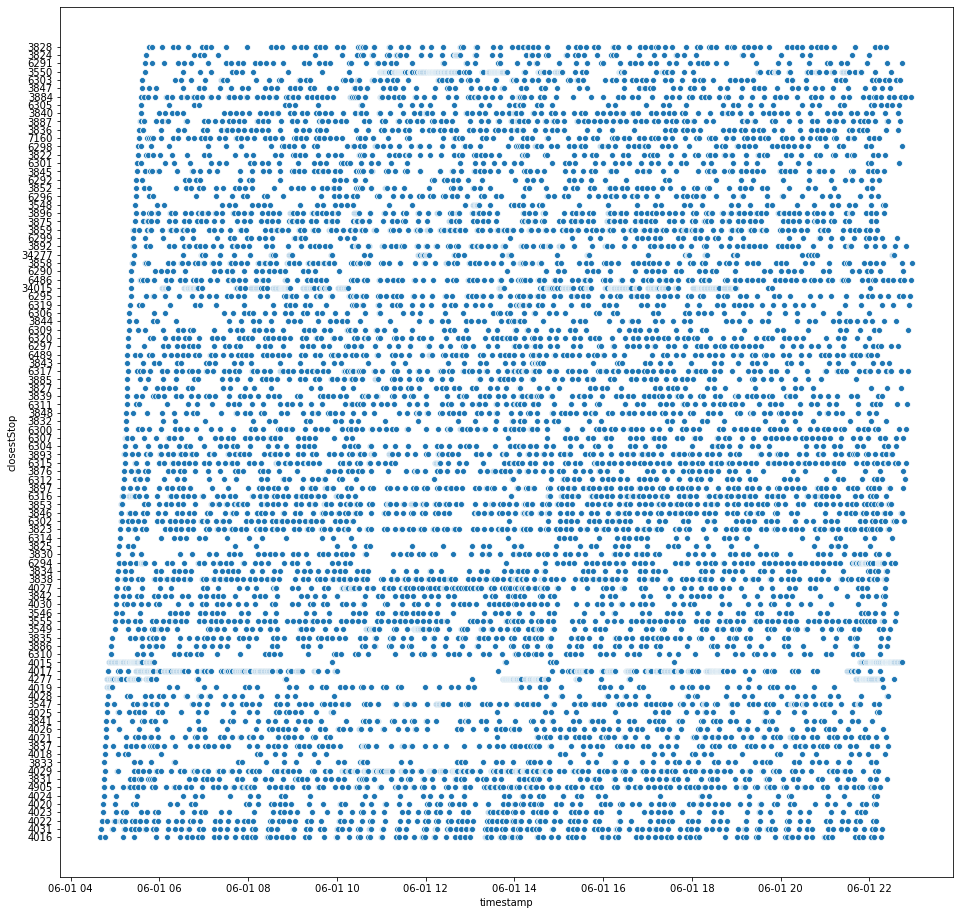

In [0]:
import matplotlib.pyplot as plt
import seaborn as sns

fig, ax = plt.subplots()
fig.set_size_inches(16, 16)

# All vehicles
sns.scatterplot(x=df['timestamp'], 
                y=df['closestStop'].astype(str))

# Single vehicle plot
# vid = 5798
# sns.scatterplot(x=df[df['vid']==vid]['timestamp'], 
#                 y=df[df['vid']==vid]['closestStop'].astype(str), 
#                 hue=df[df['vid']==vid]['direction'])

# sort Y axis by the order stops should visited in
stoplist = list(inbound_stops['tag']) + list(outbound_stops['tag'])
plt.yticks(ticks=stoplist, labels=stoplist)

plt.show()

## Calculating when each bus is at each stop

General steps:

1. Find which stop is closest to each reported location (done above)
  - This step could use improvement.  Using the closest stop will be a good approximation, but we could get more accurate by taking speed, distance, or maybe heading into account.
2. Fill in times for stops in between each location report (interpolation)
  - ![interpolation graphic](https://drive.google.com/uc?export=view&id=1lroClIK-i6_mysd5SA3mQCHsNKuy5t_r)
  - Possible improvement: the current approach assumes equal distances between stops
3. Save those times for each stop, to get a list of all times each stop sees a bus
4. Analyze that list of times the stop sees a bus to get the bunches and gaps

In [0]:
# Slimming down to just 1 vehicle so I can test faster
df_full = df.copy()
df = df[df['vid'] == 5797]

In [0]:
# This is the first inbound group
print(df.shape)
df.head(12)

(362, 12)


,id,timestamp,rid,vid,age,kph,heading,latitude,longitude,direction,closestStop,distance
0,2852834,2020-06-01 04:40:10,1,5797,2,18,75,37.7919,-122.425,1____I_S00,4016,0.059866
1,2852871,2020-06-01 04:40:59,1,5797,13,0,83,37.7921,-122.423,1____I_S00,4031,0.010048
2,2852908,2020-06-01 04:42:13,1,5797,0,11,75,37.7926,-122.420,1____I_S00,4022,0.046100
3,2852944,2020-06-01 04:43:01,1,5797,11,24,75,37.7930,-122.417,1____I_S00,4023,0.077721
4,2852981,2020-06-01 04:43:50,1,5797,22,10,75,37.7933,-122.414,1____I_S00,4020,0.070205
5,2853019,2020-06-01 04:44:51,1,5797,22,10,75,37.7936,-122.411,1____I_S00,4024,0.020698
8,2853058,2020-06-01 04:45:52,1,5797,20,10,75,37.7940,-122.408,1____I_S00,4029,0.049569
11,2853097,2020-06-01 04:46:53,1,5797,19,18,75,37.7943,-122.406,1____I_S00,4018,0.005542
14,2853137,2020-06-01 04:47:54,1,5797,18,0,80,37.7944,-122.405,1____I_S00,4021,0.065990
17,2853177,2020-06-01 04:48:55,1,5797,18,14,75,37.7947,-122.403,1____I_S00,4025,0.025584


In [0]:
# The inbound and outbound lists have stops in the correct order
inbound[:5]

['4277', '3555', '3548', '3546', '3844']

In [0]:
# example, index of a stop
inbound.index('4016')

31

In [0]:
# example, interpolate the time between stops at rows 0 and 1
df.at[0, 'timestamp'] + (df.at[1, 'timestamp'] - df.at[0, 'timestamp'])/2

Timestamp('2020-06-01 04:40:34.500000')

In [0]:
%%time

# Initialize the data structure I will store results in
# Dict with the stop tag as a key, and a list of timestamps
stop_times = {}
for stop in inbound + outbound:
  stop_times[str(stop)] = []

for vid in df_full['vid'].unique():
  # Process the route one vehicle at a time
  df = df_full[df_full['vid'] == vid]

  # process 1st row on its own
  prev_row = df.loc[df.index[0]]
  stop_times[str(prev_row['closestStop'])].append(prev_row['timestamp'])

  # loop through the rest of the rows, comparing each to the previous one
  for i, row in df[1:].iterrows():
    if row['direction'] != prev_row['direction']:
      # changed directions, don't compare to previous row
      stop_times[str(row['closestStop'])].append(row['timestamp'])
    else:
      # same direction, compare to previous
      if '_I_' in row['direction']:  # get correct stop list
        stoplist = inbound
      else:
        stoplist = outbound

      current = stoplist.index(str(row['closestStop']))
      previous = stoplist.index(str(prev_row['closestStop']))
      gap = current - previous
      if gap > 1:  # need to interpolate
        diff = (row['timestamp'] - prev_row['timestamp'])/gap
        counter = 1
        for stop in stoplist[previous+1:current]:
          # save interpolated time
          stop_times[str(stop)].append(prev_row['timestamp'] + (counter * diff))
          # print('interpolated time for stop', stop)

          # increase counter for the next stop
          # example: with 2 interpolated stops, gap would be 3
          # 1st diff is 1/3, next is 2/3
          counter += 1
      
      if row['closestStop'] != prev_row['closestStop']:
        # only save time if the stop has changed, 
        # otherwise the bus hasn't moved since last time
        stop_times[str(row['closestStop'])].append(row['timestamp'])
    
    # advance for next row
    prev_row = row

CPU times: user 2.39 s, sys: 0 ns, total: 2.39 s
Wall time: 2.39 s


In [0]:
# meta-analysis
total = 0
for key in stop_times.keys():
  total += len(stop_times[key])
  print(f"Stop {key} recorded {len(stop_times[key])} timestamps")

print(f"\n{total} total timestamps were recorded, meaning {total - len(df_full)} were interpolated")

Stop 4277 recorded 32 timestamps
Stop 3555 recorded 122 timestamps
Stop 3548 recorded 127 timestamps
Stop 3546 recorded 128 timestamps
Stop 3844 recorded 130 timestamps
Stop 3842 recorded 130 timestamps
Stop 3840 recorded 131 timestamps
Stop 3838 recorded 132 timestamps
Stop 3836 recorded 132 timestamps
Stop 3834 recorded 132 timestamps
Stop 3887 recorded 132 timestamps
Stop 3832 recorded 132 timestamps
Stop 3830 recorded 133 timestamps
Stop 3827 recorded 133 timestamps
Stop 3825 recorded 133 timestamps
Stop 3823 recorded 133 timestamps
Stop 3846 recorded 134 timestamps
Stop 3853 recorded 134 timestamps
Stop 3897 recorded 134 timestamps
Stop 3876 recorded 130 timestamps
Stop 3893 recorded 124 timestamps
Stop 3848 recorded 120 timestamps
Stop 3859 recorded 120 timestamps
Stop 3885 recorded 120 timestamps
Stop 6489 recorded 121 timestamps
Stop 6296 recorded 121 timestamps
Stop 6320 recorded 120 timestamps
Stop 6292 recorded 121 timestamps
Stop 6306 recorded 122 timestamps
Stop 6310 recor

## Finding bunches and gaps

Now that we have the lists of each time a bus was at each stop, we can go through those lists to check if the times were long or short enough to be bunches or gaps.

In [0]:
# Expected headway (in minutes)
schedule.common_interval

8.0

In [0]:
%%time
# sort every array so that the times are in order
for stop in stop_times.keys():
  stop_times[stop].sort()

CPU times: user 5.59 ms, sys: 0 ns, total: 5.59 ms
Wall time: 5.54 ms


In [0]:
%%time

# Initialize dataframe for the bunces and gaps
problems = pd.DataFrame(columns=['type', 'time', 'duration', 'stop'])
counter = 0

# Set the bunch/gap thresholds (in seconds)
bunch_threshold = (schedule.common_interval * 60) * .2  # 20%
gap_threshold = (schedule.common_interval * 60) * 1.5   # 150%

for stop in stop_times.keys():
  # ensure we have a time at all for this stop
  if len(stop_times[stop]) == 0:
    print(f"Stop {stop} had no recorded times")
    continue  # go to next stop in the loop

  # save initial time
  prev_time = stop_times[stop][0]

  # loop through all others, comparing to the previous one
  for time in stop_times[stop][1:]:
    diff = (time - prev_time).seconds
    if diff <= bunch_threshold:
      # bunch found, save it
      problems.at[counter] = ['bunch', prev_time, diff, stop]
      counter += 1
    elif diff >= gap_threshold:
      problems.at[counter] = ['gap', prev_time, diff, stop]
      counter += 1
    
    prev_time = time

CPU times: user 2.39 s, sys: 35.6 ms, total: 2.43 s
Wall time: 2.37 s


In [0]:
# type - 'bunch' or 'gap'
# time - the start time of the problem interval
# duration - the length of the interval, in seconds
# stop - the stop this interval was recorded at

problems[problems['type'] == 'gap']

,type,time,duration,stop
0,gap,2020-06-01 05:00:48,853,4277
1,gap,2020-06-01 05:42:01,784,4277
2,gap,2020-06-01 05:55:05,3365,4277
3,gap,2020-06-01 06:51:10,7136,4277
4,gap,2020-06-01 08:50:06,15142,4277
...,...,...,...,...
2400,gap,2020-06-01 17:00:05,3005,34277
2401,gap,2020-06-01 17:50:10,1614,34277
2402,gap,2020-06-01 18:17:04,2337,34277
2403,gap,2020-06-01 18:56:01,5581,34277


In [0]:
problems[problems['type'] == 'bunch']

,type,time,duration,stop
6,bunch,2020-06-01 13:44:03,25,4277
7,bunch,2020-06-01 14:34:38,79,4277
13,bunch,2020-06-01 21:49:39,13,4277
24,bunch,2020-06-01 13:58:05,63,3555
25,bunch,2020-06-01 14:05:01,25,3555
...,...,...,...,...
2342,bunch,2020-06-01 21:45:51,82,3549
2355,bunch,2020-06-01 10:57:48,12,3550
2364,bunch,2020-06-01 14:31:52,64,3550
2377,bunch,2020-06-01 20:36:08,62,3550


In [0]:
# how many is that?
bunches = len(problems[problems['type'] == 'bunch'])
gaps = len(problems[problems['type'] == 'gap'])
intervals = total-len(stop_times)

print(f"Out of {intervals} recorded intervals, we found {bunches} bunches and {gaps} gaps")
print(f"\t{(bunches/intervals)*100 : .2f}% bunched")
print(f"\t{(gaps/intervals)*100 : .2f}% gapped")

Out of 11385 recorded intervals, we found 532 bunches and 1873 gaps
	 4.67% bunched
	 16.45% gapped


## On time percentage

We can also use the list of stop times to calculate on-time percentage.  For each expected time, did we have a bus there on time?

SFMTA defines "on time" as "within four minutes late or one minute early of the scheduled arrival time"

- source: https://www.sfmta.com/reports/muni-time-performance

We don't have enough precision in our data to distinguish arrivals and departures from every specific stop, so our results may not match up exactly with SFMTA's reported results.  That website reports monthly statistics, but not daily.

These approximations also do not have info on which bus is supposed to be which trip.  This code does not distinguish between early or late if a scheduled stop was missed, because we do not know if the bus before or after was supposed to make that stop.

In [0]:
# Remind myself what I'm working with
schedule.inbound_table.head(10)

,4277,3825,3893,3848,6296,4026,4027,4028,34015
0,NaN,NaN,NaN,04:32:00,04:37:00,04:44:00,04:50:00,04:56:00,04:59:00
1,NaN,NaN,NaN,04:40:00,04:45:00,04:52:00,04:58:00,05:04:00,05:07:00
2,NaN,NaN,NaN,04:48:00,04:53:00,05:00:00,05:06:00,05:12:00,05:15:00
3,NaN,NaN,NaN,04:56:00,05:01:00,05:08:00,05:14:00,05:20:00,05:23:00
4,NaN,NaN,NaN,05:04:00,05:09:00,05:16:00,05:22:00,05:28:00,05:31:00
5,NaN,NaN,NaN,05:12:00,05:17:00,05:24:00,05:30:00,05:36:00,05:39:00
6,05:00:00,05:10:00,05:16:00,NaN,05:21:00,05:28:00,05:34:00,05:40:00,05:43:00
7,NaN,NaN,NaN,05:20:00,05:25:00,05:32:00,05:38:00,05:44:00,05:47:00
8,05:08:00,05:18:00,05:24:00,NaN,05:29:00,05:36:00,05:42:00,05:48:00,05:51:00
9,05:16:00,05:26:00,05:32:00,NaN,05:37:00,05:44:00,05:50:00,05:56:00,05:59:00


In [0]:
# What times did we actually see?
stop_times['4026'][:10]

[Timestamp('2020-06-01 04:41:36'),
 Timestamp('2020-06-01 04:47:30'),
 Timestamp('2020-06-01 04:58:02.500000'),
 Timestamp('2020-06-01 05:05:05'),
 Timestamp('2020-06-01 05:13:17.500000'),
 Timestamp('2020-06-01 05:22:05.500000'),
 Timestamp('2020-06-01 05:26:47.500000'),
 Timestamp('2020-06-01 05:32:50'),
 Timestamp('2020-06-01 05:41:55.500000'),
 Timestamp('2020-06-01 05:52:08.500000')]

In [0]:
pd.to_datetime(inbound_times['4277'])

0                     NaT
1                     NaT
2                     NaT
3                     NaT
4                     NaT
              ...        
153   2020-06-08 22:16:00
154   2020-06-08 22:24:00
155   2020-06-08 22:32:00
156   2020-06-08 22:40:00
157   2020-06-08 22:48:00
Name: 4277, Length: 158, dtype: datetime64[ns]

In [0]:
# Save schedules with timestamp data types, set date to match
example = df_full['timestamp'][0]

inbound_times = schedule.inbound_table
for col in inbound_times.columns:
  inbound_times[col] = pd.to_datetime(inbound_times[col]).apply(
      lambda dt: dt.replace(year=example.year, 
                            month=example.month, 
                            day=example.day))

outbound_times = schedule.outbound_table
for col in outbound_times.columns:
  outbound_times[col] = pd.to_datetime(outbound_times[col]).apply(
      lambda dt: dt.replace(year=example.year, 
                            month=example.month, 
                            day=example.day))

In [0]:
%%time
# This performs a sequential search to find observed times that match 
# expected times.  Could switch to a binary search to improve speed if needed.

def count_on_time(expected_times, observed_times):
  """ Returns the number of on-time stops found """

  # set up early/late thresholds (in seconds)
  early_threshold = pd.Timedelta(seconds=1*60)  # 1 minute early
  late_threshold = pd.Timedelta(seconds=4*60)   # 4 minutes late

  count = 0
  for stop in expected_times.columns:
    for expected in expected_times[stop]:
      if pd.isna(expected):
        continue  # skip NaT values in the expected schedule

      # for each expected time...
      # find first observed time after the early threshold
      found_time = None
      early = expected - early_threshold
      for observed in observed_times[stop]:
        if observed >= early:
          found_time = observed
          break 

      # if found time is still None, then all observed times were too early
      # if found_time is before the late threshold then we were on time
      if (not pd.isna(found_time)) and found_time <= (expected + late_threshold):
        # found_time is within the on-time window
        count += 1

  return count

# count times for both inbound and outbound schedules
on_time_count = (count_on_time(inbound_times, stop_times) + 
                 count_on_time(outbound_times, stop_times))

# get total expected count
total_expected = inbound_times.count().sum() + outbound_times.count().sum()

# and there we have it, the on-time percentage
print(f"Found {on_time_count} on time stops out of {total_expected} scheduled")
print(f"On-time percentage is {(on_time_count/total_expected)*100 : .2f}%\n")

Found 952 on time stops out of 2324 scheduled
On-time percentage is 40.96%

CPU times: user 60.5 ms, sys: 2 ms, total: 62.5 ms
Wall time: 66.2 ms


## Bunches and Gaps Line Graph


In [0]:
problems.head()

,type,time,duration,stop
0,gap,2020-06-08 05:16:11,1720,3603
1,gap,2020-06-08 05:44:51,1262,3603
2,gap,2020-06-08 06:05:53,1509,3603
3,gap,2020-06-08 06:31:02,773,3603
4,gap,2020-06-08 06:43:55,1022,3603


In [0]:
index = pd.DatetimeIndex(problems['time'])
df = problems.copy()
df.index = index
df.head()

,type,time,duration,stop
time,,,,
2020-06-08 05:16:11,gap,2020-06-08 05:16:11,1720,3603
2020-06-08 05:44:51,gap,2020-06-08 05:44:51,1262,3603
2020-06-08 06:05:53,gap,2020-06-08 06:05:53,1509,3603
2020-06-08 06:31:02,gap,2020-06-08 06:31:02,773,3603
2020-06-08 06:43:55,gap,2020-06-08 06:43:55,1022,3603


In [0]:
# How to select rows between a time
interval = pd.Timedelta(minutes=10)

select_start = pd.to_datetime('2020/6/8 11:00:00')
select_end = select_start + interval

df.between_time(select_start.time(), select_end.time())

,type,time,duration,stop
time,,,,
2020-06-08 11:01:00,gap,2020-06-08 11:01:00,776,5692
2020-06-08 11:05:05,gap,2020-06-08 11:05:05,838,5650
2020-06-08 11:08:00,gap,2020-06-08 11:08:00,835,5644
2020-06-08 11:04:04,bunch,2020-06-08 11:04:04,61,6738


In [0]:
import matplotlib.pyplot as plt

def draw_bunch_gap_graph(problems, interval=5):
  """
  plots a graph of the bunches and gaps throughout the day

  problems - the dataframe of bunches and gaps

  interval - the number of minutes to bin data into
  """

  # generate the DatetimeIndex needed
  index = pd.DatetimeIndex(problems['time'])
  df = problems.copy()
  df.index = index

  # lists for graph data
  bunches = []
  gaps = []
  times = []

  # set the time interval and selectino times
  interval = pd.Timedelta(minutes=interval)
  start_date = problems.at[0, 'time'].replace(hour=0, minute=0, second=0)
  select_start = start_date
  select_end = date + interval

  while select_start.day == start_date.day:
    # get the count of each type of problem in this time interval
    count = df.between_time(select_start.time(), select_end.time())['type'].value_counts()

    # append the counts to the data list
    if 'bunch' in count.index:
      bunches.append(count['bunch'])
    else:
      bunches.append(0)
    
    if 'gap' in count.index:
      gaps.append(count['gap'])
    else:
      gaps.append(0)

    # save the start time for the x axis
    times.append(str(select_start.time())[:5])
    
    # increment the selection window
    select_start += interval
    select_end += interval

  # draw the graph
  fig, ax = plt.subplots()
  fig.set_size_inches(16, 6)

  plt.plot(times, bunches, label='Bunches')
  plt.plot(times, gaps, label='Gaps')

  plt.title(f"Bunches and Gaps for route {rid} on {str(pd.to_datetime(begin).date())}")
  ax.xaxis.set_major_locator(plt.MaxNLocator(24))  # limit number of ticks on x-axis
  plt.legend()
  plt.show()

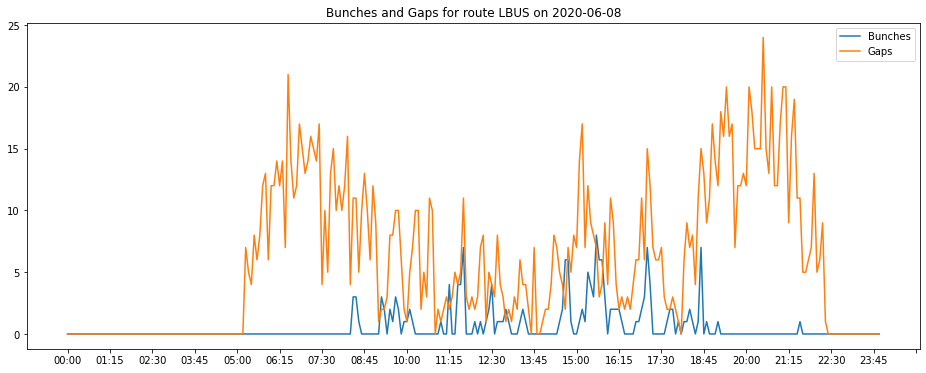

In [0]:
bunch_gap_graph(problems, interval=5)

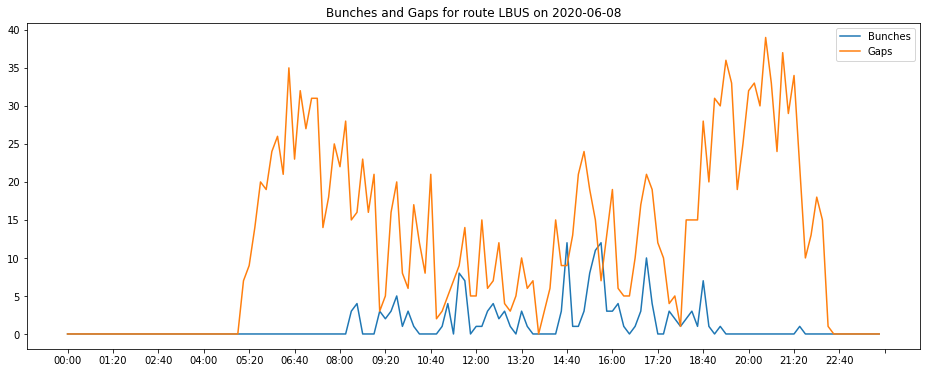

In [0]:
bunch_gap_graph(problems, interval=10)

# Cleaning code

The above code achieves what we're after: it finds the number of bunches and gaps in a given route on a given day, and also calculates the on-time percentage.

The code below can be run on it's own, and does not include any of the exploratory bits.

## Run Once

In [0]:
# Used in many places
import psycopg2 as pg
import pandas as pd

# Used to enter database credentials without saving them to the notebook file
import getpass

# Used to easily read in bus location data
import pandas.io.sql as sqlio

# Only used in the schedule class definition
import numpy as np
from scipy import stats

# Used in the fcc_projection function to find distances
from math import sqrt, cos

# Used at the end, to convert the final product to JSON
import json

/usr/local/lib/python3.6/dist-packages/psycopg2/__init__.py:144: UserWarning: The psycopg2 wheel package will be renamed from release 2.8; in order to keep installing from binary please use "pip install psycopg2-binary" instead. For details see: <http://initd.org/psycopg/docs/install.html#binary-install-from-pypi>.
  """)


In [0]:
# Enter database credentials.  Requires you to paste in the user and
# password so it isn't saved in the notebook file
print("Enter database username:")
user = getpass.getpass()
print("Enter database password:")
password = getpass.getpass()

creds = {
  'user': user,
  'password': password,
  'host': "lambdalabs24sfmta.cykkiwxbfvpg.us-east-1.rds.amazonaws.com",
  'dbname': "historicalTransitData"
}

# Set up connection to database
cnx = pg.connect(**creds)
cursor = cnx.cursor()

print('\nDatabase connection successful')

Enter database username:
··········
Enter database password:
··········

Database connection successful


In [0]:
# Schedule class definition
# Copied from previous work, has extra methods that are not all used in this notebook

class Schedule:
    def __init__(self, route_id, date, connection):
        """
        The Schedule class loads the schedule for a particular route and day,
        and makes several accessor methods available for it.

        Parameters:

        route_id (str or int)
            - The route id to load

        date (str or pandas.Timestamp)
            - Which date to load
            - Converted with pandas.to_datetime so many formats are acceptable
        """

        self.route_id = str(route_id)
        self.date = pd.to_datetime(date)

        # load the schedule for that date and route
        self.route_data = load_schedule(self.route_id, self.date, connection)

        # process data into a table
        self.inbound_table, self.outbound_table = extract_schedule_tables(self.route_data)

        # calculate the common interval values
        self.mean_interval, self.common_interval = get_common_intervals(
                                    [self.inbound_table, self.outbound_table])

    def list_stops(self):
        """
        returns the list of all stops used by this schedule
        """

        # get stops for both inbound and outbound routes
        inbound = list(self.inbound_table.columns)
        outbound = list(self.outbound_table.columns)

        # convert to set to ensure no duplicates,
        # then back to list for the correct output type
        return list(set(inbound + outbound))

    def get_specific_interval(self, stop, time, inbound=True):
        """
        Returns the expected interval, in minutes, for a given stop and
        time of day.

        Parameters:

        stop (str or int)
            - the stop tag/id of the bus stop to check

        time (str or pandas.Timestamp)
            - the time of day to check, uses pandas.to_datetime to convert
            - examples that work: "6:00", "3:30pm", "15:30"

        inbound (bool, optional)
            - whether to check the inbound or outbound schedule
            - ignored unless the given stop is in both inbound and outbound
        """

        # ensure correct parameter types
        stop = str(stop)
        time = pd.to_datetime(time)

        # check which route to use, and extract the column for the given stop
        if (stop in self.inbound_table.columns and
        stop in self.outbound_table.columns):
            # stop exists in both, use inbound parameter to decide
            if inbound:
                sched = self.inbound_table[stop]
            else:
                sched = self.outbound_table[stop]
        elif (stop in self.inbound_table.columns):
            # stop is in the inbound schedule, use that
            sched = self.inbound_table[stop]
        elif (stop in self.outbound_table.columns):
            # stop is in the outbound schedule, use that
            sched = self.outbound_table[stop]
        else:
            # stop doesn't exist in either, throw an error
            raise ValueError(f"Stop id '{stop}' doesn't exist in either inbound or outbound schedules")

        # 1: convert schedule to datetime for comparison statements
        # 2: drop any NaN values
        # 3: convert to list since pd.Series threw errors on i indexing
        sched = list(pd.to_datetime(sched).dropna())

        # reset the date portion of the time parameter to
        # ensure we are checking the schedule correctly
        time = time.replace(year=self.date.year, month=self.date.month,
                            day=self.date.day)

        # iterate through that list to find where the time parameter fits
        for i in range(1, len(sched)):
            # start at 1 and move forward,
            # is the time parameter before this schedule entry?
            if(time < sched[i]):
                # return the difference between this entry and the previous one
                return (sched[i] - sched[i-1]).seconds / 60

        # can only reach this point if the time parameter is after all entries
        # in the schedule, return the last available interval
        return (sched[len(sched)-1] - sched[len(sched)-2]).seconds / 60


def load_schedule(route, date, connection):
    """
    loads schedule data from the database and returns it

    Parameters:

        route (str)
            - The route id to load

        date (str or pd.Timestamp)
            - Which date to load
            - Converted with pandas.to_datetime so many formats are acceptable
    """

    # ensure correct parameter types
    route = str(route)
    date = pd.to_datetime(date)

    # DB connection
    cursor = connection.cursor()

    # build selection query
    query = """
        SELECT content
        FROM schedules
        WHERE rid = %s AND
            begin_date <= %s::TIMESTAMP AND
            (end_date IS NULL OR end_date >= %s::TIMESTAMP);
    """

    # execute query and save the route data to a local variable
    cursor.execute(query, (route, str(date), str(date)))
    data = cursor.fetchone()[0]['route']

    # pd.Timestamp.dayofweek returns 0 for monday and 6 for Sunday
    # the actual serviceClass strings are defined by Nextbus
    # these are the only 3 service classes we can currently observe,
    # if others are published later then this will need to change
    if(date.dayofweek <= 4):
        serviceClass = 'wkd'
    elif(date.dayofweek == 5):
        serviceClass = 'sat'
    else:
        serviceClass = 'sun'

    # the schedule format has two entries for each serviceClass,
    # one each for inbound and outbound.

    # return each entry in the data list with the correct serviceClass
    return [sched for sched in data if (sched['serviceClass'] == serviceClass)]


def extract_schedule_tables(route_data):
    """
    converts raw schedule data to two pandas dataframes

    columns are stops, and rows are individual trips

    returns inbound_df, outbound_df
    """

    # assuming 2 entries, but not assuming order
    if(route_data[0]['direction'] == 'Inbound'):
        inbound = 0
    else:
        inbound = 1

    # extract a list of stops to act as columns
    inbound_stops = [s['tag'] for s in route_data[inbound]['header']['stop']]

    # initialize dataframe
    inbound_df = pd.DataFrame(columns=inbound_stops)

    # extract each row from the data
    if type(route_data[inbound]['tr']) == list:
        # if there are multiple trips in a day, structure will be a list
        i = 0
        for trip in route_data[inbound]['tr']:
            for stop in trip['stop']:
                # '--' indicates the bus is not going to that stop on this trip
                if stop['content'] != '--':
                    inbound_df.at[i, stop['tag']] = stop['content']
            # increment for the next row
            i += 1
    else:
        # if there is only 1 trip in a day, the object is a dict and
        # must be handled slightly differently
        for stop in route_data[inbound]['tr']['stop']:
            if stop['content'] != '--':
                    inbound_df.at[0, stop['tag']] = stop['content']

    # flip between 0 and 1
    outbound = int(not inbound)

    # repeat steps for the outbound schedule
    outbound_stops = [s['tag'] for s in route_data[outbound]['header']['stop']]
    outbound_df = pd.DataFrame(columns=outbound_stops)

    if type(route_data[outbound]['tr']) == list:
        i = 0
        for trip in route_data[outbound]['tr']:
            for stop in trip['stop']:
                if stop['content'] != '--':
                    outbound_df.at[i, stop['tag']] = stop['content']
            i += 1
    else:
        for stop in route_data[outbound]['tr']['stop']:
            if stop['content'] != '--':
                    outbound_df.at[0, stop['tag']] = stop['content']

    # return both dataframes
    return inbound_df, outbound_df


def get_common_intervals(df_list):
    """
    takes route schedule tables and returns both the average interval (mean)
    and the most common interval (mode), measured in number of minutes

    takes a list of dataframes and combines them before calculating statistics

    intended to combine inbound and outbound schedules for a single route
    """

    # ensure we have at least one dataframe
    if len(df_list) == 0:
        raise ValueError("Function requires at least one dataframe")

    # append all dataframes in the array together
    df = df_list[0].copy()
    for i in range(1, len(df_list)):
        df.append(df_list[i].copy())

    # convert all values to datetime so we can get an interval easily
    for col in df.columns:
        df[col] = pd.to_datetime(df[col])

    # initialize a table to hold each individual interval
    intervals = pd.DataFrame(columns=df.columns)
    intervals['temp'] = range(len(df))

    # take each column and find the intervals in it
    for col in df.columns:
        prev_time = np.nan
        for i in range(len(df)):
            # find the first non-null value and save it to prev_time
            if pd.isnull(prev_time):
                prev_time = df.at[i, col]
            # if the current time is not null, save the interval
            elif ~pd.isnull(df.at[i, col]):
                intervals.at[i, col] = (df.at[i, col] - prev_time).seconds / 60
                prev_time = df.at[i, col]

    # this runs without adding a temp column, but the above loop runs 3x as
    # fast if the rows already exist
    intervals = intervals.drop('temp', axis=1)

    # calculate the mean of the entire table
    mean = intervals.mean().mean()

    # calculate the mode of the entire table, the [0][0] at the end is
    # because scipy.stats returns an entire ModeResult class
    mode = stats.mode(intervals.values.flatten())[0][0]

    return mean, mode

In [0]:
# Route class definition
# Copied from previous work, has extra methods that are not all used in this notebook

class Route:
    def __init__(self, route_id, date, connection):
        """
        The Route class loads the route configuration data for a particular
        route, and makes several accessor methods available for it.

        Parameters:

        route_id (str or int)
            - The route id to load

        date (str or pandas.Timestamp)
            - Which date to load
            - Converted with pandas.to_datetime so many formats are acceptable
        """

        self.route_id = str(route_id)
        self.date = pd.to_datetime(date)

        # load the route data
        self.route_data, self.route_type, self.route_name = load_route(self.route_id, self.date, connection)

        # extract stops info and rearrange columns to be more human readable
        # note: the stop tag is what was used in the schedule data, not stopId
        self.stops_table = pd.DataFrame(self.route_data['stop'])
        self.stops_table = self.stops_table[['stopId', 'tag', 'title', 'lat', 'lon']]

        # extract route path, list of (lat, lon) pairs
        self.path_coords = extract_path(self.route_data)

        # extract stops table
        self.stops_table, self.inbound, self.outbound = extract_stops(self.route_data)


def load_route(route, date, connection):
    """
    loads raw route data from the database

    Parameters:

        route (str or int)
            - The route id to load

        date (str or pd.Timestamp)
            - Which date to load
            - Converted with pandas.to_datetime so many formats are acceptable
    
    Returns route_data (dict), route_type (str), route_name (str)
    """

    # ensure correct parameter types
    route = str(route)
    date = pd.to_datetime(date)

    # DB connection
    cursor = connection.cursor()

    # build selection query
    query = """
        SELECT route_name, route_type, content
        FROM routes
        WHERE rid = %s AND
            begin_date <= %s::TIMESTAMP AND
            (end_date IS NULL OR end_date > %s::TIMESTAMP);
    """

    # execute query and return the route data
    cursor.execute(query, (route, str(date), str(date)))
    result = cursor.fetchone()
    return result[2]['route'], result[1], result[0]


def extract_path(route_data):
    """
    Extracts the list of path coordinates for a route.

    The raw data stores this as an unordered list of sub-routes, so this
    function deciphers the order they should go in and returns a single list.
    """

    # KNOWN BUG
    # this approach assumed all routes were either a line or a loop.
    # routes that have multiple sub-paths meeting at a point break this,
    # route 24 is a current example.
    # I'm committing this now to get the rest of the code out there

    # extract the list of subpaths as just (lat,lon) coordinates
    # also converts from string to float (raw data has strings)
    path = []
    for sub_path in route_data['path']:
        path.append([(float(p['lat']), float(p['lon'])) 
                     for p in sub_path['point']])

    # start with the first element, remove it from path
    final = path[0]
    path.pop(0)

    # loop until the first and last coordinates in final match
    counter = len(path)
    done = True
    while final[0] != final[-1]:
        # loop through the sub-paths that we haven't yet moved to final
        for i in range(len(path)):
            # check if the last coordinate in final matches the first 
            # coordinate of another sub-path
            if final[-1] == path[i][0]:
                # match found, move it to final
                # leave out the first coordinate to avoid duplicates
                final = final + path[i][1:]
                path.pop(i)
                break  # break the for loop
                
        # protection against infinite loops, if the path never closes
        counter -= 1
        if counter < 0:
            done = False
            break

    if not done:
        # route did not connect in a loop, perform same steps backwards 
        # to get the rest of the line
        for _ in range(len(path)):
            # loop through the sub-paths that we haven't yet moved to final
            for i in range(len(path)):
                # check if the first coordinate in final matches the last 
                # coordinate of another sub-path
                if final[0] == path[i][-1]:
                    # match found, move it to final
                    # leave out the last coordinate to avoid duplicates
                    final = path[i][:-1] + final
                    path.pop(i)
                    break  # break the for loop

    # some routes may have un-used sub-paths
    # Route 1 for example has two sub-paths that are almost identical, with the 
    # same start and end points
    # if len(path) > 0:
    #     print(f"WARNING: {len(path)} unused sub-paths")

    # return the final result
    return final


def extract_stops(route_data):
  """
  Extracts a dataframe of stops info

  Returns the main stops dataframe, and a list of inbound and outbound stops 
  in the order they are intended to be on the route
  """

  stops = pd.DataFrame(route_data['stop'])
  directions = pd.DataFrame(route_data['direction'])

  # Change stop arrays to just the list of numbers
  for i in range(len(directions)):
    directions.at[i, 'stop'] = [s['tag'] for s in directions.at[i, 'stop']]

  # Find which stops are inbound or outbound
  inbound = []
  for stop_list in directions[directions['name'] == "Inbound"]['stop']:
    for stop in stop_list:
      if stop not in inbound:
        inbound.append(stop)

  outbound = []
  for stop_list in directions[directions['name'] == "Outbound"]['stop']:
    for stop in stop_list:
      if stop not in inbound:
        outbound.append(stop)

  # Label each stop as inbound or outbound
  stops['direction'] = ['none'] * len(stops)
  for i in range(len(stops)):
    if stops.at[i, 'tag'] in inbound:
      stops.at[i, 'direction'] = 'inbound'
    elif stops.at[i, 'tag'] in outbound:
      stops.at[i, 'direction'] = 'outbound'

  # Convert from string to float
  stops['lat'] = stops['lat'].astype(float)
  stops['lon'] = stops['lon'].astype(float)

  return stops, inbound, outbound

In [0]:
def get_location_data(rid, begin, end, connection):
  # Build query to select location data
  query = f"""
    SELECT *
    FROM locations
    WHERE rid = '{rid}' AND
      timestamp > '{begin}'::TIMESTAMP AND
      timestamp < '{end}'::TIMESTAMP
    ORDER BY id;
  """

  # read the query directly into pandas
  locations = sqlio.read_sql_query(query, connection)

  # Convert those UTC timestamps to local PST by subtracting 7 hours
  locations['timestamp'] = locations['timestamp'] - pd.Timedelta(hours=7)

  # return the result
  return locations


In [0]:
# Written by Austie
def fcc_projection(loc1, loc2):
    """
    function to apply FCC recommended formulae
    for calculating distances on earth projected to a plane
    
    significantly faster computationally, negligible loss in accuracy
    
    Args: 
    loc1 - a tuple of lat/lon
    loc2 - a tuple of lat/lon
    """
    lat1, lat2 = loc1[0], loc2[0]
    lon1, lon2 = loc1[1], loc2[1]
    
    mean_lat = (lat1+lat2)/2
    delta_lat = lat2 - lat1
    delta_lon = lon2 - lon1
    
    k1 = 111.13209 - 0.56605*cos(2*mean_lat) + .0012*cos(4*mean_lat)
    k2 = 111.41513*cos(mean_lat) - 0.09455*cos(3*mean_lat) + 0.00012*cos(5*mean_lat)
    
    distance = sqrt((k1*delta_lat)**2 + (k2*delta_lon)**2)
    
    return distance


In [0]:
def clean_locations(locations, stops):
  """
  takes a dataframe of bus locations and a dataframe of 

  returns the locations dataframe with nearest stop added
  """
  
  # remove old location reports that would be duplicates
  df = locations[locations['age'] < 60].copy()

  # remove rows with no direction value
  df = df[~pd.isna(df['direction'])]

  # shift timestamps according to the age column
  df['timestamp'] = df.apply(shift_timestamp, axis=1)

  # Make lists of all inbound or outbound stops
  inbound_stops = stops[stops['direction'] == 'inbound'].reset_index(drop=True)
  outbound_stops = stops[stops['direction'] == 'outbound'].reset_index(drop=True)

  # initialize new columns for efficiency
  df['closestStop'] = [0] * len(df)
  df['distance'] = [0.0] * len(df)

  for i in df.index:
    if '_I_' in df.at[i, 'direction']:
      candidates = inbound_stops
    elif '_O_' in df.at[i, 'direction']:
      candidates = outbound_stops
    else:
      # Skip row if bus is not found to be either inbound or outbound
      continue
    
    bus_coord = (df.at[i, 'latitude'], df.at[i, 'longitude'])

    # Find closest stop within candidates
    # Assume the first stop
    closest = candidates.iloc[0]
    distance = fcc_projection(bus_coord, (closest['lat'], closest['lon']))

    # Check each stop after that
    for _, row in candidates[1:].iterrows():
      # find distance to this stop
      dist = fcc_projection(bus_coord, (row['lat'], row['lon']))
      if dist < distance:
        # closer stop found, save it
        closest = row
        distance = dist
    
    # Save the tag of the closest stop and the distance to it
    df.at[i, 'closestStop'] = closest['tag']
    df.at[i, 'distance'] = distance

  return df


def shift_timestamp(row):
  """ subtracts row['age'] from row['timestamp'] """
  return row['timestamp'] - pd.Timedelta(seconds=row['age'])

In [0]:
def get_stop_times(locations, route):
  """
  returns a dict, keys are stop tags and values are lists of timestamps 
  that describe every time a bus was seen at that stop
  """

  # Initialize the data structure I will store results in
  stop_times = {}
  for stop in route.inbound + route.outbound:
    stop_times[str(stop)] = []

  for vid in locations['vid'].unique():
    # Process the route one vehicle at a time
    df = locations[locations['vid'] == vid]

    # process 1st row on its own
    prev_row = df.loc[df.index[0]]
    stop_times[str(prev_row['closestStop'])].append(prev_row['timestamp'])

    # loop through the rest of the rows, comparing each to the previous one
    for i, row in df[1:].iterrows():
      if row['direction'] != prev_row['direction']:
        # changed directions, don't compare to previous row
        stop_times[str(row['closestStop'])].append(row['timestamp'])
      else:
        # same direction, compare to previous row
        if '_I_' in row['direction']:  # get correct stop list
          stoplist = route.inbound
        else:
          stoplist = route.outbound

        current = stoplist.index(str(row['closestStop']))
        previous = stoplist.index(str(prev_row['closestStop']))
        gap = current - previous
        if gap > 1:  # need to interpolate
          diff = (row['timestamp'] - prev_row['timestamp'])/gap
          counter = 1
          for stop in stoplist[previous+1:current]:
            # save interpolated time
            stop_times[str(stop)].append(prev_row['timestamp'] + (counter * diff))

            # increase counter for the next stop
            # example: with 2 interpolated stops, gap would be 3
            # 1st diff is 1/3, next is 2/3
            counter += 1
        
        if row['closestStop'] != prev_row['closestStop']:
          # only save time if the stop has changed, 
          # otherwise the bus hasn't moved since last time
          stop_times[str(row['closestStop'])].append(row['timestamp'])
      
      # advance for next row
      prev_row = row
  
  # Sort each list before returning
  for stop in stop_times.keys():
    stop_times[stop].sort()

  return stop_times


In [0]:
def get_bunches_gaps(stop_times, schedule, bunch_threshold=.2, gap_threshold=1.5):
  """
  returns a dataframe of all bunches and gaps found

  default thresholds define a bunch as 20% and a gap as 150% of scheduled headway
  """

  # Initialize dataframe for the bunces and gaps
  problems = pd.DataFrame(columns=['type', 'time', 'duration', 'stop'])
  counter = 0

  # Set the bunch/gap thresholds (in seconds)
  bunch_threshold = (schedule.common_interval * 60) * bunch_threshold
  gap_threshold = (schedule.common_interval * 60) * gap_threshold

  for stop in stop_times.keys():
    # ensure we have any times at all for this stop
    if len(stop_times[stop]) == 0:
      #print(f"Stop {stop} had no recorded times")
      continue  # go to next stop in the loop

    # save initial time
    prev_time = stop_times[stop][0]

    # loop through all others, comparing to the previous one
    for time in stop_times[stop][1:]:
      diff = (time - prev_time).seconds
      if diff <= bunch_threshold:
        # bunch found, save it
        problems.at[counter] = ['bunch', prev_time, diff, stop]
        counter += 1
      elif diff >= gap_threshold:
        problems.at[counter] = ['gap', prev_time, diff, stop]
        counter += 1
      
      prev_time = time
  
  return problems


In [0]:
# this uses sequential search, could speed up with binary search if needed,
# but it currently uses hardly any time in comparison to other steps
def helper_count(expected_times, observed_times):
  """ Returns the number of on-time stops found """

  # set up early/late thresholds (in seconds)
  early_threshold = pd.Timedelta(seconds=1*60)  # 1 minute early
  late_threshold = pd.Timedelta(seconds=4*60)   # 4 minutes late

  count = 0
  for stop in expected_times.columns:
    for expected in expected_times[stop]:
      if pd.isna(expected):
        continue  # skip NaN values in the expected schedule

      # for each expected time...
      # find first observed time after the early threshold
      found_time = None
      early = expected - early_threshold

      # BUG: some schedule data may have stop tags that are not in the inbound
      # or outbound definitions for a route.  That would throw a key error here.
      # Example: stop 14148 on route 24
      # current solution is to ignore those stops with the try/except statement
      try:
        for observed in observed_times[stop]:
          if observed >= early:
            found_time = observed
            break
      except:
        continue

      # if found time is still None, then all observed times were too early
      # if found_time is before the late threshold then we were on time
      if (not pd.isna(found_time)) and found_time <= (expected + late_threshold):
        # found_time is within the on-time window
        count += 1

  return count

def calculate_ontime(stop_times, schedule):
  """ Returns the on-time percentage and total scheduled stops for this route """

  # Save schedules with timestamp data types, set date to match
  inbound_times = schedule.inbound_table
  for col in inbound_times.columns:
    inbound_times[col] = pd.to_datetime(inbound_times[col]).apply(
        lambda dt: dt.replace(year=schedule.date.year, 
                              month=schedule.date.month, 
                              day=schedule.date.day))

  outbound_times = schedule.outbound_table
  for col in outbound_times.columns:
    outbound_times[col] = pd.to_datetime(outbound_times[col]).apply(
        lambda dt: dt.replace(year=schedule.date.year, 
                              month=schedule.date.month, 
                              day=schedule.date.day))
  
  # count times for both inbound and outbound schedules
  on_time_count = (helper_count(inbound_times, stop_times) +
                   helper_count(outbound_times, stop_times))
  
  # get total expected count
  total_expected = inbound_times.count().sum() + outbound_times.count().sum()

  # return on-time percentage
  return (on_time_count / total_expected), total_expected


In [0]:
def bunch_gap_graph(problems, interval=10):
  """
  returns data for a graph of the bunches and gaps throughout the day

  problems - the dataframe of bunches and gaps

  interval - the number of minutes to bin data into

  returns
  {
    "times": [time values (x)],
    "bunches": [bunch counts (y1)],
    "gaps": [gap counts (y2)]
  }
  """

  # set the time interval
  interval = pd.Timedelta(minutes=interval)

  # rest of code doesn't work if there are no bunches or gaps
  # return the empty graph manually
  if len(problems) == 0:
    # generate list of times according to the interval
    start = pd.Timestamp('today').replace(hour=0, minute=0, second=0)
    t = start
    times = []
    while t.day == start.day:
      times.append(str(t.time())[:5])
      t += interval

    return {
      "times": times,
      "bunches": [0] * len(times),
      "gaps": [0] * len(times)
    }

  # generate the DatetimeIndex needed
  index = pd.DatetimeIndex(problems['time'])
  df = problems.copy()
  df.index = index

  # lists for graph data
  bunches = []
  gaps = []
  times = []
  
  # set selection times
  start_date = problems.at[0, 'time'].replace(hour=0, minute=0, second=0)
  select_start = start_date
  select_end = select_start + interval

  while select_start.day == start_date.day:
    # get the count of each type of problem in this time interval
    count = df.between_time(select_start.time(), select_end.time())['type'].value_counts()

    # append the counts to the data list
    if 'bunch' in count.index:
      bunches.append(int(count['bunch']))
    else:
      bunches.append(0)
    
    if 'gap' in count.index:
      gaps.append(int(count['gap']))
    else:
      gaps.append(0)

    # save the start time for the x axis
    times.append(str(select_start.time())[:5])
    
    # increment the selection window
    select_start += interval
    select_end += interval
  
  return {
    "times": times,
    "bunches": bunches,
    "gaps": gaps
  }

In [0]:
def create_simple_geojson(bunches, rid):

    geojson = {'type': 'FeatureCollection',
               'bunches': create_geojson_features(bunches, rid)}

    return geojson

def create_geojson_features(df, rid):
    """
    function to generate list of geojson features
    for plotting vehicle locations on timestamped map

    Expects a dataframe containing lat/lon, vid, timestamp
    returns list of basic geojson formatted features:

    {
      type: Feature
      geometry: {
        type: Point,
        coordinates:[lat, lon]
      },
      properties: {
        route_id: rid
        time: timestamp
      }
    }
    """
    # initializing empty features list
    features = []

    # iterating through df to pull coords, vid, timestamp
    # and format for json
    for index, row in df.iterrows():
      feature = {
          'type': 'Feature',
          'geometry': {
              'type':'Point', 
              'coordinates':[row.lon, row.lat]
          },
          'properties': {
              'time': row.time.__str__(),
              'stop': {'stopId': row.stopId.__str__(),
                       'stopTitle': row.title.__str__()},
              'direction': row.direction.__str__()
          }
      }
      features.append(feature) # adding point to features list
    return features

## Run each time to get a new report

### Timing breakdown

In [0]:
# Change this one cell to change to a different route/day
# Uses 7am to account for the UTC to PST conversion
rid = "1"
begin = "2020/6/1 07:00:00"
end = "2020/6/2 07:00:00"

In [0]:
%%time
# Most time in this cell is waiting on the database responses

# Load schedule and route data
schedule = Schedule(rid, begin, cnx)
route = Route(rid, begin, cnx)

# Load bus location data
locations = get_location_data(rid, begin, end, cnx)

CPU times: user 674 ms, sys: 34.2 ms, total: 708 ms
Wall time: 4.43 s


In [0]:
%%time
# Apply cleaning function (this usually takes 1-2 minutes)
locations = clean_locations(locations, route.stops_table)

CPU times: user 1min 3s, sys: 27.8 ms, total: 1min 3s
Wall time: 1min 3s


In [0]:
%%time
# Calculate all times a bus was at each stop
stop_times = get_stop_times(locations, route)

CPU times: user 2.48 s, sys: 1.99 ms, total: 2.48 s
Wall time: 2.49 s


In [0]:
%%time
# Find all bunches and gaps
problems = get_bunches_gaps(stop_times, schedule)

CPU times: user 2.28 s, sys: 4.04 ms, total: 2.28 s
Wall time: 2.28 s


In [0]:
%%time
# Calculate on-time percentage
on_time, total_scheduled = calculate_ontime(stop_times, schedule)

CPU times: user 228 ms, sys: 1.01 ms, total: 229 ms
Wall time: 232 ms


In [0]:
%%time
# Get the bunch/gap graph
bg_graph = bunch_gap_graph(problems, interval=10)

CPU times: user 236 ms, sys: 2.01 ms, total: 238 ms
Wall time: 244 ms


In [0]:
%%time
# Generate the geojson object
bunch_df = problems[problems.type.eq('bunch')]
bunch_df = bunch_df.merge(route.stops_table, left_on='stop', right_on='tag', how='left')

# Creating GeoJSON of bunch times / locations
geojson = create_simple_geojson(bunch_df, rid)

CPU times: user 110 ms, sys: 1.01 ms, total: 111 ms
Wall time: 121 ms


In [0]:
# Print results
print(f"--- Report for route {rid} on {str(pd.to_datetime(begin).date())} ---")

total = 0
for key in stop_times.keys():
  total += len(stop_times[key])

intervals = total-len(stop_times)
bunches = len(problems[problems['type'] == 'bunch'])
gaps = len(problems[problems['type'] == 'gap'])

print(f"\nOut of {intervals} recorded intervals, we found {bunches} bunches and {gaps} gaps")
print(f"\t{(bunches/intervals)*100 : .2f}% bunched")
print(f"\t{(gaps/intervals)*100 : .2f}% gapped")

print(f"\nFound {int(on_time * total_scheduled + .5)} on-time stops out of {total_scheduled} scheduled")
print(f"On-time percentage is {(on_time)*100 : .2f}%")

--- Report for route 1 on 2020-06-01 ---

Out of 11385 recorded intervals, we found 532 bunches and 1873 gaps
	 4.67% bunched
	 16.45% gapped

Found 952 on-time stops out of 2324 scheduled
On-time percentage is  40.96%


### All in one function

In [0]:
# Expect this cell to take 60-90 seconds to run

# Change this to change to a different route/day
# Uses 7am to account for the UTC to PST conversion
# rid = "LBUS"
# begin = "2020/6/8 07:00:00"
# end = "2020/6/9 07:00:00"

def print_report(rid, date):
  """
  Prints a daily report for the given rid and date

  rid : (str)
    the route id to generate a report for
  
  date : (str or pd.Datetime)
    the date to generate a report for
  """

  # get begin and end timestamps for the date
  begin = pd.to_datetime(date).replace(hour=7)
  end = begin + pd.Timedelta(days=1)

  # Load schedule and route data
  schedule = Schedule(rid, begin, cnx)
  route = Route(rid, begin, cnx)

  # Load bus location data
  locations = get_location_data(rid, begin, end, cnx)

  # Apply cleaning function (this usually takes 1-2 minutes)
  locations = clean_locations(locations, route.stops_table)

  # Calculate all times a bus was at each stop
  stop_times = get_stop_times(locations, route)

  # Find all bunches and gaps
  problems = get_bunches_gaps(stop_times, schedule)

  # Calculate on-time percentage
  on_time, total_scheduled = calculate_ontime(stop_times, schedule)

  # Print results
  print(f"--- Report for route {rid} on {str(pd.to_datetime(begin).date())} ---")

  total = 0
  for key in stop_times.keys():
    total += len(stop_times[key])

  intervals = total-len(stop_times)
  bunches = len(problems[problems['type'] == 'bunch'])
  gaps = len(problems[problems['type'] == 'gap'])

  print(f"\nOut of {intervals} recorded intervals, we found {bunches} bunches and {gaps} gaps")
  print(f"\t{(bunches/intervals)*100 :.2f}% bunched")
  print(f"\t{(gaps/intervals)*100 :.2f}% gapped")

  print(f"\nFound {int(on_time * total_scheduled + .5)} on-time stops out of {total_scheduled} scheduled")
  print(f"On-time percentage is {(on_time)*100 :.2f}%")

  coverage = (total_scheduled * on_time + bunches) / total_scheduled
  print(f"\nCoverage is {coverage * 100 :.2f}%")

In [0]:
print_report(rid='1', date='2020/6/2')

--- Report for route 1 on 2020-06-02 ---

Out of 12348 recorded intervals, we found 731 bunches and 1713 gaps
	5.92% bunched
	13.87% gapped

Found 1066 on-time stops out of 2324 scheduled
On-time percentage is 45.87%

Coverage is 77.32%


In [0]:
print_report(rid='5', date='2020/6/2')

--- Report for route 5 on 2020-06-02 ---

Out of 3266 recorded intervals, we found 111 bunches and 467 gaps
	3.40% bunched
	14.30% gapped

Found 528 on-time stops out of 1327 scheduled
On-time percentage is 39.79%

Coverage is 48.15%


## Generating report JSON

In [0]:
def generate_report(rid, date):
  """
  Generates a daily report for the given rid and date

  rid : (str)
    the route id to generate a report for
  
  date : (str or pd.Datetime)
    the date to generate a report for

  returns a dict of the report info
  """

  # get begin and end timestamps for the date
  begin = pd.to_datetime(date).replace(hour=7)
  end = begin + pd.Timedelta(days=1)
  # Load schedule and route data
  schedule = Schedule(rid, begin, cnx)
  
  route = Route(rid, begin, cnx)
  
  # Load bus location data
  locations = get_location_data(rid, begin, end, cnx)
  
  # Apply cleaning function (this usually takes 1-2 minutes)
  locations = clean_locations(locations, route.stops_table)
  
  # Calculate all times a bus was at each stop
  stop_times = get_stop_times(locations, route)

  # Find all bunches and gaps
  problems = get_bunches_gaps(stop_times, schedule)

  # Calculate on-time percentage
  on_time, total_scheduled = calculate_ontime(stop_times, schedule)

  # Build result dict
  count_times = 0
  for key in stop_times.keys():
    count_times += len(stop_times[key])

  # Number of recorded intervals ( sum(len(each list of time)) - number or lists of times)
  intervals = count_times-len(stop_times)

  bunches = len(problems[problems['type'] == 'bunch'])
  gaps = len(problems[problems['type'] == 'gap'])

  coverage = (total_scheduled * on_time + bunches) / total_scheduled

  # Isolating bunches, merging with stops to assign locations to bunches
  bunch_df = problems[problems.type.eq('bunch')]
  bunch_df = bunch_df.merge(route.stops_table, left_on='stop', right_on='tag', how='left')

  # Creating GeoJSON of bunch times / locations
  geojson = create_simple_geojson(bunch_df, rid)
  
  # int/float conversions are because the json library doesn't work with numpy types
  result = {
      'route_id': rid,
      'route_name': route.route_name,
      'route_type': route.route_type,
      'date': str(pd.to_datetime(date)),
      'overall_health': 0,  # TODO: implement this
      'num_bunches': bunches,
      'num_gaps': gaps,
      'total_intervals': intervals,
      'on_time_percentage': float(round(on_time * 100, 2)),
      'scheduled_stops': int(total_scheduled),
      'coverage': float(round(coverage * 100, 2)),
      # line_chart contains all data needed to generate the line chart
      'line_chart': bunch_gap_graph(problems, interval=10),
      # route_table is an array of all rows that should show up in the table
      # it will be filled in after all reports are generated
      'route_table': [
          {
            'route_id': rid,
            'route_name': route.route_name,
            'bunches': bunches,
            'gaps': gaps,
            'on-time': float(round(on_time * 100, 2)),
            'coverage': float(round(coverage * 100, 2))
          }
      ],
      'map_data': geojson
  }

  return result

In [0]:
# Route 1 usage example
report_1 = generate_report(rid='1', date='2020/6/1')

In [0]:
report_1.keys()

dict_keys(['route_id', 'route_name', 'route_type', 'date', 'overall_health', 'num_bunches', 'num_gaps', 'total_intervals', 'on_time_percentage', 'scheduled_stops', 'coverage', 'line_chart', 'route_table', 'map_data'])

In [0]:
# Route 714 usage example
report_714 = generate_report(rid='714', date='2020/6/1')

In [0]:
print('Route:', report_714['route_name'])
print('Bunches:', report_714['num_bunches'])
print('Gaps:', report_714['num_gaps'])
print('On-time:', report_714['on_time_percentage'])
print('Coverage:', report_714['coverage'])

Route: 714-Bart Early Bird
Bunches: 0
Gaps: 0
On-time: 55.56
Coverage: 55.56


# Generating report for all routes

In [0]:
def get_active_routes(date):
  """
  returns a list of all active route id's for the given date
  """

  query = """
    SELECT DISTINCT rid
    FROM routes
    WHERE begin_date <= %s ::TIMESTAMP AND
          (end_date IS NULL OR end_date > %s ::TIMESTAMP);
  """

  cursor.execute(query, (date, date))
  return [result[0] for result in cursor.fetchall()]

In [0]:
%%time
# since this is not optimized yet, this takes about 20 minutes

# choose a day
date = '2020-6-1'

# get all active routes 
route_ids = get_active_routes(date)
route_ids.sort()

# get the report for all routes
all_reports = []
for rid in route_ids:
  try:
    all_reports.append(generate_report(rid, date))
    print("Generated report for route", rid)
  except: # in case any particular route throws an error
    print(f"Route {rid} failed")

Generated report for route 1
Generated report for route 12
Generated report for route 14
Generated report for route 14R
Generated report for route 19
Generated report for route 22
Generated report for route 24
Generated report for route 25
Generated report for route 28
Generated report for route 29
Generated report for route 38
Generated report for route 38R
Generated report for route 44
Generated report for route 49
Generated report for route 5
Generated report for route 54
Generated report for route 714
Generated report for route 8
Generated report for route 9
Generated report for route 90
Generated report for route 91
Generated report for route 9R
Generated report for route LBUS
Generated report for route L_OWL
Generated report for route MBUS
Generated report for route NBUS
Generated report for route N_OWL
Generated report for route TBUS
CPU times: user 20min 16s, sys: 1.16 s, total: 20min 17s
Wall time: 20min 57s


In [0]:
len(all_reports)

28

In [0]:
# generate aggregate reports

# read existing reports into a dataframe to work with them easily
df = pd.DataFrame(all_reports)

# for each aggregate type
types = ['All'] + list(df['route_type'].unique())
counter = 0
for t in types:
  # filter df to the routes we are adding up
  if t == 'All':
    filtered = df
  else:
    filtered = df[df['route_type'] == t]

  # on-time percentage: sum([all on-time stops]) / sum([all scheduled stops])
  count_on_time = (filtered['on_time_percentage'] * filtered['scheduled_stops']).sum()
  on_time_perc = count_on_time / filtered['scheduled_stops'].sum()

  # coverage: (sum([all on-time stops]) + sum([all bunches])) / sum([all scheduled stops])
  coverage = (count_on_time + filtered['num_bunches'].sum()) / filtered['scheduled_stops'].sum()

  # aggregate the graph object
  # x-axis is same for all
  first = filtered.index[0]
  times = filtered.at[first, 'line_chart']['times']

  # sum up all y-axis values
  bunches = pd.Series(filtered.at[first, 'line_chart']['bunches'])
  gaps = pd.Series(filtered.at[first, 'line_chart']['gaps'])

  # same pattern for the geojson list
  geojson = filtered.at[first, 'map_data']['bunches']

  for i, report in filtered[1:].iterrows():
    # pd.Series adds all values in the lists together
    bunches += pd.Series(report['line_chart']['bunches'])
    gaps += pd.Series(report['line_chart']['gaps'])

    # lists concatenate together
    geojson += report['map_data']['bunches']

  # save a new report object
  new_report = {
      'route_id': t,
      'route_name': t,
      'route_type': t,
      'date': all_reports[0]['date'],
      'overall_health': 0,  # TODO, implement.  Either avg of all routes, or recalculate using the aggregate statistics
      'num_bunches': int(filtered['num_bunches'].sum()),
      'num_gaps': int(filtered['num_gaps'].sum()),
      'total_intervals': int(filtered['total_intervals'].sum()),
      'on_time_percentage': float(round(on_time_perc, 2)),
      'scheduled_stops': int(filtered['scheduled_stops'].sum()),
      'coverage': float(round(coverage, 2)),
      'line_chart': {
          'times': times,
          'bunches': list(bunches),
          'gaps': list(gaps)
      },
      'route_table': [
          {
            'route_id': t,
            'route_name': t,
            'bunches': int(filtered['num_bunches'].sum()),
            'gaps': int(filtered['num_gaps'].sum()),
            'on-time': float(round(on_time_perc, 2)),
            'coverage': float(round(coverage, 2))
          }
      ],
      'map_data': {
          # 'type': 'FeatureCollection',
          # 'bunches': geojson
      }
  }
  
  # put aggregate reports at the beginning of the list
  all_reports.insert(counter, new_report)
  counter += 1

# Add route_table rows to the aggregate report
# Set up a dict to hold each aggregate table
tables = {}
for t in types:
  tables[t] = []

# Add rows from each report
for report in all_reports:
  # add to the route type's table
  tables[report['route_type']].append(report['route_table'][0])

  # also add to all routes table
  if report['route_id'] != "All":
    # if statement needed to not duplicate the "All" row twice
    tables['All'].append(report['route_table'][0])


# find matching report and set the table there
for key in tables.keys():
  for report in all_reports:
    if report['route_id'] == key:
      # override it because the new table includes the row that was already there
      report['route_table'] = tables[key]
      break  # only 1 report needs each aggregate table

In [0]:
len(all_reports)

33

In [0]:
# save the all_reports object to a file so I can download it
with open(f'report_{date}_slimmed.json', 'w') as outfile:
  json.dump(all_reports, outfile)

In [0]:
# rollback code if needed for testing: remove all aggregate reports
for i in reversed(range(len(all_reports))):
  if all_reports[i]['route_id'] in types:
    del(all_reports[i])

In [0]:
# save report in the database
query = """
  INSERT INTO reports (date, report)
  VALUES (%s, %s);
"""
cursor.execute(query, (date, json.dumps(all_reports)))
cnx.commit()